In [91]:
# 필요한 라이브러리 임포트
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path

# 시스템 경로에 ultralytics 폴더 추가 (모듈을 찾을 수 있도록)
sys.path.append('/home/byounggun/ultralytics')

# 모델 및 유틸리티 임포트
from yolov8_siamese import SiameseYOLOv8s
from ultralytics.utils.plotting import Annotator, colors

# CUDA 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 로드 함수
def load_siamese_model(weights_path, siamese_weights_path):
    """
    학습된 Siamese YOLOv8 모델을 로드합니다.
    
    Args:
        weights_path (str): YOLOv8 베이스 가중치 경로 (보통 'yolov8s.pt')
        siamese_weights_path (str): 학습된 Siamese 모델 가중치 경로
    
    Returns:
        model: 로드된 Siamese YOLOv8 모델
    """
    # 먼저 기본 구조 초기화
    model = SiameseYOLOv8s(yolo_weights_path=weights_path)
    
    # 학습된 가중치 로드
    ckpt = torch.load(siamese_weights_path, map_location=device)
    
    # train_siamese.py에서 저장한 체크포인트 구조에 맞게 로드
    if 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
        print(f"모델 로드 성공! 에폭: {ckpt['epoch']}, 손실: {ckpt['loss']:.4f}")
    else:
        raise ValueError("체크포인트 파일 형식이 예상과 다릅니다. 'model_state_dict' 키가 없습니다.")
    
    model = model.to(device)
    model.eval()  # 평가 모드로 설정
    
    return model

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path, img_size=640):
    """
    이미지를 로드하고 전처리합니다.
    
    Args:
        image_path (str): 이미지 파일 경로
        img_size (int): 이미지 크기 조정 값
    
    Returns:
        tuple: (원본 이미지, 전처리된 텐서)
    """
    # 이미지 로드
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 크기 및 비율 계산
    h, w = img.shape[:2]
    ratio = img_size / max(h, w)
    if ratio != 1:
        interp = cv2.INTER_LINEAR if ratio > 1 else cv2.INTER_AREA
        img_resized = cv2.resize(img, (int(w * ratio), int(h * ratio)), interpolation=interp)
    else:
        img_resized = img
    
    # 패딩 추가
    padded_h, padded_w = int(round(h * ratio)), int(round(w * ratio))
    padding = [(img_size - padded_h) // 2, (img_size - padded_w) // 2]
    img_padded = np.full((img_size, img_size, 3), 114, dtype=np.uint8)
    img_padded[padding[0]:padding[0] + padded_h, padding[1]:padding[1] + padded_w] = img_resized
    
    # 텐서로 변환 및 정규화
    img_tensor = torch.from_numpy(img_padded).permute(2, 0, 1).float().div(255.0).unsqueeze(0)
    
    return img, img_tensor

# 예측 결과 시각화 함수
def visualize_predictions(img, predictions, names, conf_threshold=0.25):
    """
    객체 감지 예측 결과를 시각화합니다.
    
    Args:
        img (numpy.ndarray): 원본 이미지
        predictions (torch.Tensor): 모델의 예측 결과
        names (list): 클래스 이름 목록
        conf_threshold (float): 신뢰도 임계값
    
    Returns:
        numpy.ndarray: 바운딩 박스가 그려진 이미지
    """
    img_with_boxes = img.copy()
    h, w = img.shape[:2]
    
    # Annotator 초기화
    annotator = Annotator(img_with_boxes, line_width=2)
    
    if predictions.shape[0] > 0:
        # 신뢰도 기준으로 필터링
        predictions = predictions[predictions[:, 4] > conf_threshold]
        
        for det in predictions:
            x1, y1, x2, y2, conf, cls = det[:6]
            c = int(cls)
            label = f'{names[c]} {conf:.2f}'
            
            # 바운딩 박스 그리기
            annotator.box_label([x1, y1, x2, y2], label, color=colors(c, True))
    
    return annotator.result()

# 시암 특징 유사도 시각화 함수
def visualize_similarity(siamese_emb_wide, siamese_emb_narrow):
    """
    시암 네트워크의 특징 유사도를 시각화합니다.
    
    Args:
        siamese_emb_wide (torch.Tensor): 광각 이미지의 특징 임베딩
        siamese_emb_narrow (torch.Tensor): 협각 이미지의 특징 임베딩
    
    Returns:
        float: 코사인 유사도 점수
    """
    # 코사인 유사도 계산
    similarity = F.cosine_similarity(siamese_emb_wide, siamese_emb_narrow).item()
    
    return similarity

# 실행 함수
# 실행 함수
def run_inference(model, wide_img_path, narrow_img_path, conf_threshold=0.25):
    """
    Siamese YOLOv8 모델로 추론을 실행합니다.
    """
    # 이미지 로드 및 전처리
    wide_img_orig, wide_img_tensor = load_and_preprocess_image(wide_img_path)
    narrow_img_orig, narrow_img_tensor = load_and_preprocess_image(narrow_img_path)
    
    # 모델을 확실히 평가 모드로 설정
    model.eval()
    model.training = False
    
    # 모델 추론 실행
    with torch.no_grad():
        wide_img_tensor = wide_img_tensor.to(device)
        narrow_img_tensor = narrow_img_tensor.to(device)
        
        # 시암 네트워크의 forward 메소드에 두 이미지 전달
        feat_wide_tuple = model.shared_backbone(wide_img_tensor)
        feat_narrow_tuple = model.shared_backbone(narrow_img_tensor)
        
        # 시암 특징 추출
        siamese_emb_wide = model._extract_siamese_features(feat_wide_tuple)
        siamese_emb_narrow = model._extract_siamese_features(feat_narrow_tuple)
        
        # 객체 감지 예측
        detection_output = model.detection_head(feat_wide_tuple)
        
        # 출력 형식 확인 및 디버깅
        print(f"Detection output type: {type(detection_output)}")
        if isinstance(detection_output, (list, tuple)):
            print(f"Output is a {type(detection_output).__name__} of length {len(detection_output)}")
            for i, item in enumerate(detection_output):
                if torch.is_tensor(item):
                    print(f"Item {i} is a tensor with shape {item.shape} and dtype {item.dtype}")
                else:
                    print(f"Item {i} is a {type(item).__name__}")
        elif torch.is_tensor(detection_output):
            print(f"Output is a tensor with shape {detection_output.shape} and dtype {detection_output.dtype}")
        
        # 코사인 유사도 계산
        similarity = torch.nn.functional.cosine_similarity(
            siamese_emb_wide, siamese_emb_narrow
        ).item()
    
    # 이미지만 표시 (객체 감지 결과 없이)
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(wide_img_orig)
    plt.title("광각 이미지 (원본)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(narrow_img_orig)
    plt.title("협각 이미지 (원본)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"광각-협각 이미지 코사인 유사도: {similarity:.4f}")
    
    return detection_output, similarity

# 기존 SiameseYOLOv8s 코드에 추론 전용 메서드 추가
def predict_with_siamese(self, x_wide, x_narrow):
    """
    추론을 위한 전용 메서드 - 바운딩 박스와 시암 유사도 반환
    """
    self.eval()  # 평가 모드 설정
    
    # 특징 추출
    feat_wide_tuple = self.shared_backbone(x_wide)
    feat_narrow_tuple = self.shared_backbone(x_narrow)
    
    # 시암 특징 추출
    siamese_emb_wide = self._extract_siamese_features(feat_wide_tuple)
    siamese_emb_narrow = self._extract_siamese_features(feat_narrow_tuple)
    
    # 유사도 계산
    similarity = F.cosine_similarity(siamese_emb_wide, siamese_emb_narrow)
    
    # YOLO 원시 출력
    raw_output = self.detection_head(feat_wide_tuple)
    
    # YOLO 출력을 후처리하여 바운딩 박스 얻기
    # 여기서는 ultralytics.utils.ops 모듈의 non_max_suppression 같은 함수 사용 가능
    from ultralytics.utils.ops import non_max_suppression
    
    # YOLOv8 원시 출력을 적절히 변환 (이 부분은 YOLOv8 버전과 구현에 따라 달라질 수 있음)
    # 예시: conf_thres=0.25, iou_thres=0.45로 NMS 적용
    detections = non_max_suppression(raw_output, conf_thres=0.25, iou_thres=0.45)
    
    return detections, similarity

# 모델 로드 및 추론 실행 예시
# 아래 경로를 실제 경로로 수정하세요
if __name__ == "__main__":
    # 경로 설정
    yolo_base_weights = "yolov8s.pt"  # YOLOv8 기본 가중치
    siamese_model_weights = "/home/byounggun/ultralytics/runs/my_siamese_training/experiment1/best.pt"  # 학습된 시암 모델 가중치
    
    # 테스트 이미지 경로
    wide_img_path = "/home/byounggun/ultralytics/traffics/wide_images_only/train/images/wide_t1_001.jpg"
    narrow_img_path = "/home/byounggun/ultralytics/traffics/narrow_images_only/train/images/narrow_t1_001.jpg"
    
    # 모델 로드
    model = load_siamese_model(yolo_base_weights, siamese_model_weights)
    
    # 추론 실행
    predictions, similarity = run_inference(model, wide_img_path, narrow_img_path)

    # 시각화
    wide_img_orig, wide_img_tensor = load_and_preprocess_image(wide_img_path)
    narrow_img_orig, narrow_img_tensor = load_and_preprocess_image(narrow_img_path)
    
    # 예측 결과 시각화
    wide_img_with_boxes = visualize_predictions(wide_img_orig, predictions[0], model.names)
    narrow_img_with_boxes = visualize_predictions(narrow_img_orig, predictions[0], model.names)
    
    # 결과 이미지 표시
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(wide_img_with_boxes)
    plt.title("광각 이미지 (예측 결과)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(narrow_img_with_boxes)
    plt.title("협각 이미지 (예측 결과)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"광각-협각 이미지 코사인 유사도: {similarity:.4f}")

Using device: cuda
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512


FileNotFoundError: [Errno 2] No such file or directory: '/home/byounggun/ultralytics/runs/my_siamese_training/experiment1/best.pt'

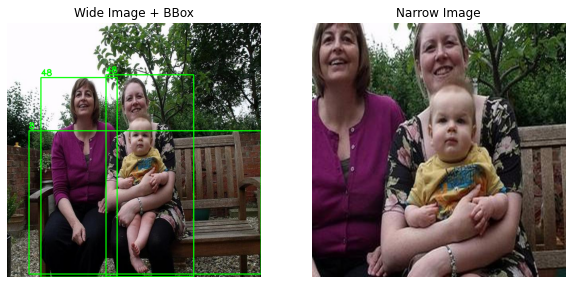

In [38]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# 데이터 경로 설정
WIDE_IMG_DIR = "/home/byounggun/cococo/train_resized/images"
NARROW_IMG_DIR = "/home/byounggun/cococo/train_short/images"
LABEL_DIR = "/home/byounggun/cococo/train_resized/labels"

# 이미지 확장자 목록
possible_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

# wide 이미지 파일 리스트
wide_files = [f for f in os.listdir(WIDE_IMG_DIR) if os.path.splitext(f)[1].lower() in possible_extensions]
assert len(wide_files) > 0, "Wide 이미지가 없습니다!"

# 랜덤 샘플 하나 선택
f_name_ext = random.choice(wide_files)
f_name, f_ext = os.path.splitext(f_name_ext)

# wide/narrow/label 경로
wide_path = os.path.join(WIDE_IMG_DIR, f_name_ext)
narrow_path = None
for ext_option in possible_extensions:
    potential_narrow_path = os.path.join(NARROW_IMG_DIR, f_name + ext_option)
    if os.path.exists(potential_narrow_path):
        narrow_path = potential_narrow_path
        break
label_path = os.path.join(LABEL_DIR, f_name + '.txt')

# 이미지 로드
wide_img = cv2.imread(wide_path)
narrow_img = cv2.imread(narrow_path) if narrow_path else None

# 라벨 로드
boxes = []
classes = []
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f:
            if line.strip() == "":
                continue
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            classes.append(int(cls))
            boxes.append([xc, yc, w, h])
boxes = np.array(boxes)

# bbox를 wide 이미지에 그리기 (YOLO 포맷 → 픽셀 좌표 변환)
def draw_yolo_boxes(img, boxes, classes, color=(0,255,0)):
    img_h, img_w = img.shape[:2]
    for (xc, yc, w, h), cls in zip(boxes, classes):
        x1 = int((xc - w/2) * img_w)
        y1 = int((yc - h/2) * img_h)
        x2 = int((xc + w/2) * img_w)
        y2 = int((yc + h/2) * img_h)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, str(cls), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return img

# 시각화
wide_img_drawn = draw_yolo_boxes(wide_img.copy(), boxes, classes)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(wide_img_drawn, cv2.COLOR_BGR2RGB))
plt.title("Wide Image + BBox")
plt.axis('off')
if narrow_img is not None:
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB))
    plt.title("Narrow Image")
    plt.axis('off')
plt.show()

Attempting to find image pairs: Wide dir: '/home/byounggun/cococo/train_resized/images', Narrow dir: '/home/byounggun/cococo/train_short/images', Label dir: '/home/byounggun/cococo/train_resized/labels'


Found 116408 image pairs for Siamese dataset.
총 페어 개수: 116408
샘플 idx: 1196
wide_img shape: (640, 640, 3)
narrow_img shape: (640, 640, 3)
labels_np: tensor([[1.8000e+01, 8.9375e-01, 5.6354e-01, 3.2813e-02, 2.5000e-02],
        [1.6000e+01, 4.6250e-01, 4.9792e-01, 3.8594e-01, 6.2708e-01],
        [4.8000e+01, 7.3828e-01, 7.3646e-01, 8.7500e-02, 3.3333e-01],
        [4.8000e+01, 7.9141e-01, 7.0938e-01, 6.5625e-02, 3.2083e-01],
        [4.8000e+01, 8.7266e-01, 7.1562e-01, 6.5625e-02, 2.2708e-01],
        [7.6000e+01, 8.7813e-01, 6.0417e-01, 6.0937e-02, 7.9167e-02],
        [8.0000e+00, 8.8750e-01, 7.6771e-01, 5.1562e-02, 1.2292e-01],
        [4.8000e+01, 4.8359e-01, 5.9896e-01, 6.5625e-02, 7.9167e-02],
        [3.5000e+01, 8.5156e-01, 6.8125e-01, 2.1875e-02, 5.0000e-02],
        [1.8000e+01, 2.5078e-01, 6.1042e-01, 5.6250e-02, 7.9167e-02],
        [8.0000e+00, 9.5469e-01, 8.1250e-01, 8.5938e-02, 3.4375e-01],
        [1.8000e+01, 8.3906e-01, 5.8021e-01, 2.3438e-02, 3.3333e-02]])
BBox: (561,

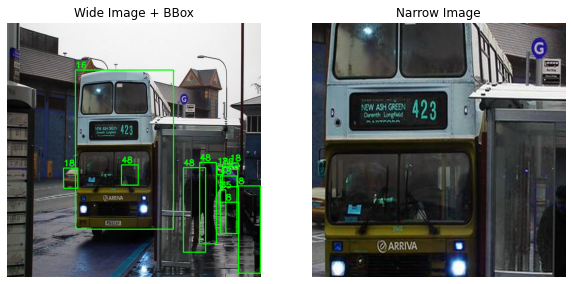

In [39]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataload_siamese import SiameseDataset

# 데이터 경로 지정
WIDE_IMG_DIR = "/home/byounggun/cococo/train_resized/images"
NARROW_IMG_DIR = "/home/byounggun/cococo/train_short/images"
LABEL_DIR = "/home/byounggun/cococo/train_resized/labels"

# transform 없이 원본만 불러오기
dataset = SiameseDataset(
    wide_img_dir=WIDE_IMG_DIR,
    narrow_img_dir=NARROW_IMG_DIR,
    label_dir=LABEL_DIR,
    img_size=640,
    transform=None
)

print(f"총 페어 개수: {len(dataset)}")

# 랜덤 샘플 하나 선택
import random
idx = random.randint(0, len(dataset)-1)

sample = dataset[idx]

# Tensor 또는 numpy 모두 지원하는 변환 함수
def tensor_to_numpy(img):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
        if img.ndim == 3 and img.shape[0] in [1, 3]:  # (C, H, W) -> (H, W, C)
            img = np.transpose(img, (1, 2, 0))
        img = np.ascontiguousarray(img)
        # 값이 [0,1] 범위면 [0,255]로 변환
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
    return img

# 반환 타입에 따라 분기
if isinstance(sample, dict):
    wide_img = sample['wide_img'] if 'wide_img' in sample else sample.get('image', None)
    narrow_img = sample['narrow_img'] if 'narrow_img' in sample else None
    labels_np = sample['labels'] if 'labels' in sample else None
else:
    # (wide_img, narrow_img, labels_np) 튜플로 반환하는 경우 (transform 없을 때)
    wide_img, narrow_img, labels_np = sample

wide_img_np = tensor_to_numpy(wide_img)
narrow_img_np = tensor_to_numpy(narrow_img)

print("샘플 idx:", idx)
print("wide_img shape:", wide_img_np.shape)
print("narrow_img shape:", narrow_img_np.shape)
print("labels_np:", labels_np)

# bbox를 wide 이미지에 그리기 (YOLO 포맷 → 픽셀 좌표 변환)
def draw_yolo_boxes(img, labels, color=(0,255,0)):
    img_h, img_w = img.shape[:2]
    for label in labels:
        if len(label) == 5:
            cls, xc, yc, w, h = label  # 순서 바꿈!
        elif len(label) == 4:
            xc, yc, w, h = label
            cls = -1
        else:
            continue
        x1 = int((xc - w/2) * img_w)
        y1 = int((yc - h/2) * img_h)
        x2 = int((xc + w/2) * img_w)
        y2 = int((yc + h/2) * img_h)
        print(f"BBox: ({x1}, {y1}), ({x2}, {y2}), class={cls}")
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return img

if labels_np is not None and len(labels_np) > 0:
    wide_img_drawn = draw_yolo_boxes(wide_img_np.copy(), labels_np)
else:
    wide_img_drawn = wide_img_np

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(wide_img_drawn, cv2.COLOR_BGR2RGB))
plt.title("Wide Image + BBox")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(narrow_img_np, cv2.COLOR_BGR2RGB))
plt.title("Narrow Image")
plt.axis('off')
plt.show()

In [35]:
import torch
from ultralytics import YOLO
from dataload_siamese import SiameseDataset, siamese_collate_fn

# --------- 1. 환경 및 데이터 준비 ---------
# 데이터셋 경로 및 하이퍼파라미터
wide_img_dir = '/home/byounggun/cococo/train_resized/images'
narrow_img_dir = '/home/byounggun/cococo/train_short/images'
label_dir = '/home/byounggun/cococo/train_resized/labels'
img_size = 640
batch_size = 2  # 원하는 배치 크기로 변경

# 데이터셋 및 DataLoader 준비
dataset = SiameseDataset(
    wide_img_dir=wide_img_dir,
    narrow_img_dir=narrow_img_dir,
    label_dir=label_dir,
    img_size=img_size,
    transform=None,  # 디버깅 시 augmentation off
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, collate_fn=siamese_collate_fn
)

# 배치 하나 추출
wide_imgs, narrow_imgs, labels = next(iter(dataloader))

# --------- 2. 모델 준비 ---------
from yolov8_siamese import SiameseYOLOv8s

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseYOLOv8s(
    yolo_weights_path='yolov8s.pt',  # 실제 사용하는 weights로 수정
    siamese_lambda=0.1,
    feature_dim=128
).to(device)
model.eval()  # 디버깅 시 eval 모드 권장

wide_imgs = wide_imgs.to(device)
narrow_imgs = narrow_imgs.to(device)

# --------- 3. 통계 함수 ---------
def print_stats(name, tensor):
    if isinstance(tensor, (list, tuple)):
        for i, t in enumerate(tensor):
            print_stats(f"{name}[{i}]", t)
        return
    print(f"{name}: shape={tuple(tensor.shape)}, "
          f"mean={tensor.mean().item():.6f}, std={tensor.std().item():.6f}, "
          f"min={tensor.min().item():.6f}, max={tensor.max().item():.6f}")

# --------- 4. Backbone Feature 통계 ---------
with torch.no_grad():
    print("=== Backbone Features (wide) ===")
    backbone_feats_wide = model.extract_backbone_features(wide_imgs)
    print_stats("BackboneWide", backbone_feats_wide)

    print("\n=== Backbone Features (narrow) ===")
    backbone_feats_narrow = model.extract_backbone_features(narrow_imgs)
    print_stats("BackboneNarrow", backbone_feats_narrow)

# --------- 5. Siamese Projector 통계 ---------
with torch.no_grad():
    print("\n=== Siamese Projector Output (wide) ===")
    siamese_feat_wide = model.siamese_projector(backbone_feats_wide[-1])
    print_stats("SiameseWide", siamese_feat_wide)

    print("\n=== Siamese Projector Output (narrow) ===")
    siamese_feat_narrow = model.siamese_projector(backbone_feats_narrow[-1])
    print_stats("SiameseNarrow", siamese_feat_narrow)

# --------- 6. Detection Head Output 통계 ---------
with torch.no_grad():
    print("\n=== Detection Head Output (wide) ===")
    detection_pred_wide = model.yolo_model(wide_imgs)
    if isinstance(detection_pred_wide, (list, tuple)):
        detection_pred_wide = detection_pred_wide[0]
    print_stats("DetectWide", detection_pred_wide)

    print("\n=== Detection Head Output (narrow) ===")
    detection_pred_narrow = model.yolo_model(narrow_imgs)
    if isinstance(detection_pred_narrow, (list, tuple)):
        detection_pred_narrow = detection_pred_narrow[0]
    print_stats("DetectNarrow", detection_pred_narrow)

Attempting to find image pairs: Wide dir: '/home/byounggun/cococo/train_resized/images', Narrow dir: '/home/byounggun/cococo/train_short/images', Label dir: '/home/byounggun/cococo/train_resized/labels'
Found 116408 image pairs for Siamese dataset.
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512
=== Backbone Features (wide) ===
BackboneWide[0]: shape=(2, 128, 80, 80), mean=0.087003, std=0.481104, min=-0.278465, max=7.991158
BackboneWide[1]: shape=(2, 256, 40, 40), mean=-0.066578, std=0.334175, min=-0.278465, max=7.023225
BackboneWide[2]: shape=(2, 512, 20, 20), mean=-0.137171, std=0.282330, min=-0.278465, max=8.117107
BackboneWide[3]: shape=(2, 256, 40, 40), mean=-0.038835, std=0.360271, min=-0.278465, max=6.934924
BackboneWide[4]: shape=(2, 128, 80, 80), mean=0.021331, std=0.350102, min=-0.278465, max=5.070144
BackboneWide[5]: shape=(2, 256, 40, 40), mean=-

In [32]:
# 필요한 import
import torch
from dataload_siamese import SiameseDataset, siamese_collate_fn, get_siamese_train_transforms

# 옵션 세팅 (train_siamese.py의 opt.* 값에 맞게 경로/파라미터 수정)
wide_img_dir = "/home/byounggun/cococo/train_resized/images"
narrow_img_dir = "/home/byounggun/cococo/train_short/images"
label_dir = "/home/byounggun/cococo/train_resized/labels"
imgsz = 640

# Dataset & DataLoader 생성
dataset = SiameseDataset(
    wide_img_dir=wide_img_dir,
    narrow_img_dir=narrow_img_dir,
    label_dir=label_dir,
    img_size=imgsz,
    transform=get_siamese_train_transforms(imgsz)
)
from torch.utils.data import DataLoader
loader = DataLoader(
    dataset,
    batch_size=4,  # 작은 배치로 확인
    shuffle=True,
    collate_fn=siamese_collate_fn
)

# 배치 하나만 추출해서 라벨 체크
wide_imgs, narrow_imgs, wide_targets = next(iter(loader))
print("wide_imgs.shape:", wide_imgs.shape)
print("wide_targets.shape:", wide_targets.shape)
print("wide_targets[:10]:\n", wide_targets[:10])

# 라벨 분포/값 확인
if wide_targets.shape[0] > 0:
    print("batch_idx (unique):", torch.unique(wide_targets[:, 0]))
    print("cls (unique):", torch.unique(wide_targets[:, 1]))
    print("x min/max:", wide_targets[:, 2].min().item(), wide_targets[:, 2].max().item())
    print("y min/max:", wide_targets[:, 3].min().item(), wide_targets[:, 3].max().item())
    print("w min/max:", wide_targets[:, 4].min().item(), wide_targets[:, 4].max().item())
    print("h min/max:", wide_targets[:, 5].min().item(), wide_targets[:, 5].max().item())
else:
    print("이 배치에는 라벨이 없습니다.")

# bbox 값이 0~1 사이인지, cls가 정상 범위(0~79)인지, batch_idx가 0~3(배치 크기-1)인지 꼭 확인해서 결과를 알려주세요!

Attempting to find image pairs: Wide dir: '/home/byounggun/cococo/train_resized/images', Narrow dir: '/home/byounggun/cococo/train_short/images', Label dir: '/home/byounggun/cococo/train_resized/labels'
Found 116408 image pairs for Siamese dataset.
wide_imgs.shape: torch.Size([4, 3, 640, 640])
wide_targets.shape: torch.Size([7, 6])
wide_targets[:10]:
 tensor([[ 0.0000,  8.0000,  0.3688,  0.2047,  0.3479,  0.0625],
        [ 0.0000, 29.0000,  0.4771,  0.5391,  0.6313,  0.7062],
        [ 1.0000, 10.0000,  0.3953,  0.5854,  0.3578,  0.3271],
        [ 2.0000, 41.0000,  0.3990,  0.3795,  0.5860,  0.5723],
        [ 2.0000, 23.0000,  0.8610,  0.4684,  0.2780,  0.4398],
        [ 3.0000, 48.0000,  0.5094,  0.4594,  0.6620,  0.8250],
        [ 3.0000, 32.0000,  0.2958,  0.3531,  0.2512,  0.0578]])
batch_idx (unique): tensor([0., 1., 2., 3.])
cls (unique): tensor([ 8., 10., 23., 29., 32., 41., 48.])
x min/max: 0.29577499628067017 0.8610000014305115
y min/max: 0.2046869993209839 0.585416972637

In [33]:
# detection_criterion이 받는 입력 예시 확인
print("wide_imgs.shape:", wide_imgs.shape)
print("wide_targets.shape:", wide_targets.shape)
print("wide_targets[:5]:\n", wide_targets[:5])

# 모델 불러오기 (train_siamese.py와 동일하게)
from train_siamese import SiameseYOLOv8s
import torch

# 임시 opt/hyp 값 세팅 (실제 학습 때와 동일하게 맞추세요)
class DummyOpt:
    weights = "/home/byounggun/ultralytics/yolov8s.pt"
    siamese_lambda = 0.1
    siamese_feature_dim = 128
    hyp = {"nc": 80}

opt = DummyOpt()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SiameseYOLOv8s(
    yolo_weights_path=opt.weights,
    siamese_lambda=opt.siamese_lambda,
    feature_dim=opt.siamese_feature_dim,
    args=opt.hyp
).to(device)
model.eval()

# 모델 예측
with torch.no_grad():
    detection_preds_wide, _ = model(wide_imgs.to(device), narrow_imgs.to(device))

print("detection_preds_wide[0].shape (if tuple):", detection_preds_wide[0].shape if isinstance(detection_preds_wide, tuple) else detection_preds_wide.shape)

# detection_criterion에 넘길 dict
print("dict for detection_criterion:")
print({
    'img': wide_imgs,
    'cls': wide_targets[:, 1:2],
    'bboxes': wide_targets[:, 2:6],
    'batch_idx': wide_targets[:, 0].long()
})

wide_imgs.shape: torch.Size([4, 3, 640, 640])
wide_targets.shape: torch.Size([7, 6])
wide_targets[:5]:
 tensor([[ 0.0000,  8.0000,  0.3688,  0.2047,  0.3479,  0.0625],
        [ 0.0000, 29.0000,  0.4771,  0.5391,  0.6313,  0.7062],
        [ 1.0000, 10.0000,  0.3953,  0.5854,  0.3578,  0.3271],
        [ 2.0000, 41.0000,  0.3990,  0.3795,  0.5860,  0.5723],
        [ 2.0000, 23.0000,  0.8610,  0.4684,  0.2780,  0.4398]])
Initializing SiameseYOLOv8s with weights: /home/byounggun/ultralytics/yolov8s.pt
Successfully extracted backbone and head from /home/byounggun/ultralytics/yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512
detection_preds_wide[0].shape (if tuple): torch.Size([4, 84, 8400])
dict for detection_criterion:
{'img': tensor([[[[ 1.0673,  1.0673,  1.0673,  ...,  1.6324,  1.6324,  1.6324],
          [ 1.0673,  1.0673,  1.0844,  ...,  1.5810,  1.5810,  1.5639],
          [ 1.0673,  1.0844,  1.0844,  ...,  1.4783,  1.4954,  1.4612],
          ...,
    

In [34]:
import torch

# detection_preds_wide[0]가 실제 예측값 (YOLOv8s는 [batch, 84, 8400])
if isinstance(detection_preds_wide, (list, tuple)):
    preds = detection_preds_wide[0]
else:
    preds = detection_preds_wide

print("preds.shape:", preds.shape)
print("preds.abs().max():", preds.abs().max().item())
print("preds.mean():", preds.mean().item())
print("preds.min():", preds.min().item(), "preds.max():", preds.max().item())

# 혹시 거의 모든 값이 0 또는 극단적으로 작은 값이면, 모델이 예측을 못하는 상태

preds.shape: torch.Size([4, 84, 8400])
preds.abs().max(): 641.072021484375
preds.mean(): 9.505587577819824
preds.min(): 2.701180953717207e-14 preds.max(): 641.072021484375


In [44]:
import sys
sys.path.append('/home/byounggun/ultralytics')

from ultralytics.utils.ops import non_max_suppression

Initializing SiameseYOLOv8s with weights: /home/byounggun/ultralytics/yolov8s.pt
Successfully extracted backbone and head from /home/byounggun/ultralytics/yolov8s.pt. NC=80, reg_max=16
[Siamese] Detected backbone output channels: 512
Selected image: /home/byounggun/ultralytics/traffic_train/wide/images/tr_084.jpg


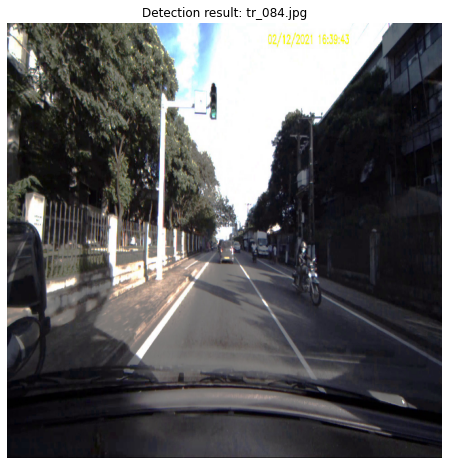

In [184]:
# Siamese YOLOv8 Inference: Random Image Each Run

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from yolov8_siamese import SiameseYOLOv8s

# 1. 경로 설정
ckpt_path = '/home/byounggun/ultralytics/runs/my_siamese_traffic/experiment3/ckpt_epoch_67.pth'  # 실제 ckpt 경로로 변경
yolo_weights_path = '/home/byounggun/ultralytics/yolov8s.pt'
img_dir = '/home/byounggun/ultralytics/traffic_train/wide/images'  # 이미지 디렉토리

# 2. 하이퍼파라미터 및 클래스 정보 로드
import yaml
with open('hyp_siamese_scratch.yaml', 'r') as f:
    hyp = yaml.safe_load(f)
dataset_yaml = '/home/byounggun/ultralytics/ultralytics/cfg/datasets/traffic.yaml'
with open(dataset_yaml, 'r') as f:
    data_yaml = yaml.safe_load(f)
names = data_yaml['names'] if isinstance(data_yaml['names'], list) else list(data_yaml['names'].values())
nc = len(names)
hyp['nc'] = nc

# 3. 모델 생성 및 체크포인트 로드 (최초 1회만)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseYOLOv8s(
    yolo_weights_path=yolo_weights_path,
    siamese_lambda=0.0,
    feature_dim=hyp.get('siamese_feature_dim', 128),
    args=hyp
).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt['model'], strict=False)
model.eval()

# 4. 무작위 이미지 선택
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
assert len(img_files) > 0, "No images found in directory!"
img_file = random.choice(img_files)
img_path = os.path.join(img_dir, img_file)
print(f"Selected image: {img_path}")

# 5. 이미지 전처리
img0 = cv2.imread(img_path)
img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (hyp.get('imgsz', 640), hyp.get('imgsz', 640)))
img_tensor = torch.from_numpy(img_resized).float().permute(2, 0, 1) / 255.0  # [C,H,W], 0~1
img_tensor = img_tensor.unsqueeze(0).to(device)

# 6. Inference (detection only)
with torch.no_grad():
    preds, _ = model(img_tensor, img_tensor)

import sys
sys.path.append('/home/byounggun/ultralytics')

from ultralytics.utils.ops import non_max_suppression
conf_thres = 0.25
iou_thres = 0.45
pred = preds[0] if isinstance(preds, (list, tuple)) else preds
dets = non_max_suppression(pred, conf_thres=conf_thres, iou_thres=iou_thres)[0]
if dets is not None and len(dets):
    dets = dets.cpu().numpy()
else:
    dets = []

# 8. 결과 시각화
img_show = img_resized.copy()
for *xyxy, conf, cls in dets:
    x1, y1, x2, y2 = map(int, xyxy)
    label = f"{names[int(cls)]}: {conf:.2f}"
    color = (0, 255, 0)
    cv2.rectangle(img_show, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img_show, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.figure(figsize=(8,8))
plt.imshow(img_show)
plt.axis('off')
plt.title(f"Detection result: {os.path.basename(img_path)}")
plt.show()

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import yaml

# 1. 경로 설정
yolo_weights_path = '/home/byounggun/ultralytics/yolov8s.pt'
img_dir = '/home/byounggun/ultralytics/traffic_train/wide'  # 교통 데이터셋 이미지 디렉토리로 변경 필요

# 2. 클래스 정보 로드
dataset_yaml = '/home/byounggun/ultralytics/ultralytics/cfg/datasets/traffic.yaml'
with open(dataset_yaml, 'r') as f:
    data_yaml = yaml.safe_load(f)
names = data_yaml['names'] if isinstance(data_yaml['names'], list) else list(data_yaml['names'].values())
nc = len(names)

# 3. 모델 생성 및 가중치 로드
from ultralytics.models.yolo.detect import DetectionModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DetectionModel(cfg='yolov8s.yaml', ch=3, nc=nc).to(device)
state_dict = torch.load(yolo_weights_path, map_location=device)
model.load_state_dict(state_dict['model'] if 'model' in state_dict else state_dict, strict=False)
model.eval()

# 4. 무작위 이미지 선택
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
assert len(img_files) > 0, "No images found in directory!"
img_file = random.choice(img_files)
img_path = os.path.join(img_dir, img_file)
print(f"Selected image: {img_path}")

# 5. 이미지 전처리
img0 = cv2.imread(img_path)
img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
imgsz = 640  # 또는 traffic.yaml에 맞는 크기
img_resized = cv2.resize(img, (imgsz, imgsz))
img_tensor = torch.from_numpy(img_resized).float().permute(2, 0, 1) / 255.0  # [C,H,W], 0~1
img_tensor = img_tensor.unsqueeze(0).to(device)

# 6. Inference
with torch.no_grad():
    preds = model(img_tensor)

from ultralytics.utils.ops import non_max_suppression
conf_thres = 0.25
iou_thres = 0.45
pred = preds[0] if isinstance(preds, (list, tuple)) else preds
dets = non_max_suppression(pred, conf_thres=conf_thres, iou_thres=iou_thres)[0]
if dets is not None and len(dets):
    dets = dets.cpu().numpy()
else:
    dets = []

# 7. 결과 시각화
img_show = img_resized.copy()
for *xyxy, conf, cls in dets:
    x1, y1, x2, y2 = map(int, xyxy)
    label = f"{names[int(cls)]}: {conf:.2f}"
    color = (0, 255, 0)
    cv2.rectangle(img_show, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img_show, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
plt.figure(figsize=(8,8))
plt.imshow(img_show)
plt.axis('off')
plt.title(f"YOLOv8s Detection: {os.path.basename(img_path)}")
plt.show()

ImportError: cannot import name 'DetectionModel' from 'ultralytics.models.yolo.detect' (/home/byounggun/ultralytics/ultralytics/models/yolo/detect/__init__.py)

In [ ]:
from ultralytics import YOLO
import os
import random
import matplotlib.pyplot as plt

# 모델 로드
# model = YOLO("/home/byounggun/ultralytics/traffic_med.pt")
model = YOLO("/home/byounggun/ultralytics/runs/my_siamese_traffic_roi/experiment_roi1/epoch_33.pt")
img_dir = '/home/byounggun/ultralytics/traffic_train/narrow/images'  # 교통 데이터셋 이미지 디렉토리로 변경 필요

# 무작위 이미지 선택
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
assert len(img_files) > 0, "No images found in directory!"
img_file = random.choice(img_files)
img_path = os.path.join(img_dir, img_file)
print(f"Selected image: {img_path}")

# 추론
results = model(img_path)

im = results[0].plot()  # plot()은 numpy array 이미지를 반환
plt.imshow(im)
plt.axis('off')
plt.show()

KeyError: 'model'